# Review Classification: Deep Learning App

First of all, this project is based on the dataset provided for the following Kaggle competition: [Amazon Reviews: Unlocked Mobile Phones](https://www.kaggle.com/PromptCloudHQ/amazon-reviews-unlocked-mobile-phones)

**Objective:**<br />

- In this notebook, I will implement all the functions required to build a deep learning model to find trends and patterns to determine which sentiment customers wrote in their reviews.

**After this code:**<br />

- I'll have a trained model to predict texts in categories (negative, neutral, positive). For this, I used mainly `keras` package.


Let's get started!

## 1 - Packages

Let's first import all the packages that you will need during this code.

- **pandas** is a fast, powerful, flexible and easy to use open source data analysis and manipulation tool, built on top of the Python programming language.
- **numPy** is a Python library used for working with arrays. It also has functions for working in domain of linear algebra, fourier transform, and matrices.
- **matplotlib** is a comprehensive library for creating static, animated, and interactive visualizations in Python.
- **seaborn** is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics.
- **string** provides additional tools to manipulate strings.
- **re** provides full support for Perl-like regular expressions in Python.
- **scikit-learn** is a free machine learning library for Python.
- **tensorFlow** is a Python library for fast numerical computing created and released by Google. It is a foundation library that can be used to create Deep Learning models directly or by using wrapper libraries that simplify the process built on top of TensorFlow.
- **Keras** is a powerful and easy-to-use free open source Python library for developing and evaluating deep learning models.

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string, re

from sklearn import metrics
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, load_model
from keras import layers
from keras.callbacks import ModelCheckpoint

## 2 - Import data and sampling

In [2]:
df = pd.read_csv('src/Amazon_Unlocked_Mobile.csv')
df.shape

(413840, 6)

In [3]:
df = df.sample(100000, random_state=13)[['Rating', 'Reviews']] # Selecting 100k sample
df['Reviews'] = df['Reviews'].fillna('')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 13741 to 372650
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Rating   100000 non-null  int64 
 1   Reviews  100000 non-null  object
dtypes: int64(1), object(1)
memory usage: 2.3+ MB


In [5]:
df.tail() # Showing few examples

,Rating,Reviews
288436,5,Can't live without
173461,5,Seller delivered in the 2 days as he said so a...
285735,5,"Great, thanks! Just what I needed. Easy purchase."
131950,1,It was great until it began to shutdown withou...
372650,2,The phone that was sold to me as unlocked is a...


In [6]:
df['Rating'].value_counts(sort=False) # Verifying how many reviews for each rating

1    17427
2     5921
3     7706
4    14823
5    54123
Name: Rating, dtype: int64

## 3 - Preprocessing data

In [7]:
# Creating function to preprocess texts
def clean_text(text):
    
    # Remove new line characters
    text = re.sub('\s+', ' ', text)
    
    # Remove punctuation
    preprocessed_text = text.translate(str.maketrans('', '', string.punctuation))

    return preprocessed_text

# Creating function to grouping ratings
def target_sentiment(text):
    new_y=[]
    if (text in [1,2]):## 2 - Import data and sampling
        return 0 # Negative
    elif (text in [4,5]):
        return 2 # Positive
    else:
        return 1 # neutral

In [8]:
%%time
# Applying the created function
df['reviews_preproc'] = df['Reviews'].apply(clean_text)
df['new_rating'] = df['Rating'].apply(target_sentiment)
df.head(10)

Wall time: 1.52 s


,Rating,Reviews,reviews_preproc,new_rating
13741,4,Muy Bueno,Muy Bueno,2
372328,5,Sleek phone. Looks great! A good size not too ...,Sleek phone Looks great A good size not too la...,2
148548,5,GOOD,GOOD,2
215726,5,Excellent,Excellent,2
208857,5,excellent I recommend it 100 %,excellent I recommend it 100,2
73358,5,AWESOMEEEE,AWESOMEEEE,2
258210,5,Very good phone. I bought it for my mom and it...,Very good phone I bought it for my mom and it ...,2
12520,1,i hate it the screen was messed up an everythi...,i hate it the screen was messed up an everythi...,0
312657,1,We purchased this phone for our overseas trips...,We purchased this phone for our overseas trips...,0
181492,5,Just as described. Super fast delivery. Daught...,Just as described Super fast delivery Daughter...,2


In [9]:
df['new_rating'].value_counts(sort=False) # Verifying how many reviews for each new rating

0    23348
1     7706
2    68946
Name: new_rating, dtype: int64

**Label encoding**: As the dataset is categorical, we need to convert the rating labels from Neutral, Negative and Positive to a float type that our model can understand. To achieve this task, we'll implement the to_categorical method from Keras.


In [10]:
labels = tf.keras.utils.to_categorical(df['new_rating'].values, num_classes=3)

In [12]:
%%time
max_words = 10000 # the maximum number of words to keep, based on word frequency.
max_len = 500 # maximum length of all sequences. If not provided, sequences will be padded to the length of the longest individual sequence.

#Data sequencing and splitting
#We'll implement the Keras tokenizer as well as its pad_sequences method to transform our text data into 3D float data, otherwise our neural networks won't be able to be trained on it.

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['reviews_preproc'].values)

sequences = tokenizer.texts_to_sequences(df['reviews_preproc'].values) # Transforms each text in texts to a sequence of integers.

reviews = pad_sequences(sequences, maxlen=max_len)

Wall time: 2.66 s


## 4 - Split into train and test

In [18]:
X_train, X_test, y_train, y_test = train_test_split(reviews, labels, test_size=0.1, random_state= 13)
print("Train Dataset: %d reviews" % len(X_train))
print("Test Dataset: %d reviews" % len(X_test))

Train Dataset: 90000 reviews
Test Dataset: 10000 reviews


## 5 - Machine Learning

In the next cells I'll guide you through the process of building 2 Recurrent Neural Networks with Keras API.
1. **Single layer LSTM network**: well-known by achieving good results in NLP tasks when the dataset is relatively small.
2. **Bidirectional LSTM model**: More complex network and very well-known to achieve great metrics when talking about text classification.

Let's see what happens.

### 5.1 - Single layer LSTM network

In [155]:
model1 = Sequential()
model1.add(layers.Embedding(max_words, 20)) # Turns positive integers (indexes) into dense vectors of fixed size.
model1.add(layers.LSTM(units=15, activation='tanh', dropout=0.5))
model1.add(layers.Dense(units=3, activation='softmax'))
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint1 = ModelCheckpoint("03models_review_classification/ReviewClassification_best_model_SingleLSTM.hdf5",
                              monitor='val_accuracy',
                              verbose=1,
                              save_best_only=True,
                              mode='auto',
                              period=1,
                              save_weights_only=False)
history1 = model1.fit(X_train, y_train,
                     batch_size=500,
                     epochs=20,
                     validation_data=(X_test, y_test),
                     callbacks=[checkpoint1])

Epoch 1/20
180/180 [==============================] - ETA: 0s - loss: 0.7303 - accuracy: 0.7112
Epoch 00001: val_accuracy improved from -inf to 0.80860, saving model to SentimentAnalysis_best_model_SingleLSTM.hdf5
180/180 [==============================] - 112s 622ms/step - loss: 0.7303 - accuracy: 0.7112 - val_loss: 0.5144 - val_accuracy: 0.8086
Epoch 2/20
180/180 [==============================] - ETA: 0s - loss: 0.4497 - accuracy: 0.8405
Epoch 00002: val_accuracy improved from 0.80860 to 0.85360, saving model to SentimentAnalysis_best_model_SingleLSTM.hdf5
180/180 [==============================] - 112s 622ms/step - loss: 0.4497 - accuracy: 0.8405 - val_loss: 0.4155 - val_accuracy: 0.8536
Epoch 3/20
180/180 [==============================] - ETA: 0s - loss: 0.3884 - accuracy: 0.8632
Epoch 00003: val_accuracy improved from 0.85360 to 0.86000, saving model to SentimentAnalysis_best_model_SingleLSTM.hdf5
180/180 [==============================] - 112s 621ms/step - loss: 0.3884 - accura

### 5.2 - Bidirectional LSTM model

In [157]:
model2 = Sequential()
model2.add(layers.Embedding(max_words, 40, input_length=max_len)) # Turns positive integers (indexes) into dense vectors of fixed size.
model2.add(layers.Bidirectional(layers.LSTM(20, dropout=0.6)))
model2.add(layers.Dense(units=3, activation='softmax'))
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Implementing model checkpoins to save the best metric and do not lose it on training.
checkpoint2 = ModelCheckpoint("03models_review_classification/ReviewClassification_best_model_BidirectionalLSTM.hdf5",
                              monitor='val_accuracy',
                              verbose=1,
                              save_best_only=True,
                              mode='auto',
                              period=1,
                              save_weights_only=False)
history2 = model2.fit(X_train, y_train,
                     batch_size=500,
                     epochs=50,
                     validation_data=(X_test, y_test),
                     callbacks=[checkpoint2])

Epoch 1/50
180/180 [==============================] - ETA: 0s - loss: 0.6156 - accuracy: 0.7712
Epoch 00001: val_accuracy improved from -inf to 0.85110, saving model to SentimentAnalysis_best_model_BidirectionalLSTM.hdf5
180/180 [==============================] - 683s 4s/step - loss: 0.6156 - accuracy: 0.7712 - val_loss: 0.4173 - val_accuracy: 0.8511
Epoch 2/50
180/180 [==============================] - ETA: 0s - loss: 0.3866 - accuracy: 0.8616
Epoch 00002: val_accuracy improved from 0.85110 to 0.86300, saving model to SentimentAnalysis_best_model_BidirectionalLSTM.hdf5
180/180 [==============================] - 667s 4s/step - loss: 0.3866 - accuracy: 0.8616 - val_loss: 0.3754 - val_accuracy: 0.8630
Epoch 3/50
180/180 [==============================] - ETA: 0s - loss: 0.3506 - accuracy: 0.8734
Epoch 00003: val_accuracy improved from 0.86300 to 0.86560, saving model to SentimentAnalysis_best_model_BidirectionalLSTM.hdf5
180/180 [==============================] - 673s 4s/step - loss: 0.3

Epoch 26/50
180/180 [==============================] - ETA: 0s - loss: 0.2190 - accuracy: 0.9236
Epoch 00026: val_accuracy did not improve from 0.88650
180/180 [==============================] - 680s 4s/step - loss: 0.2190 - accuracy: 0.9236 - val_loss: 0.3629 - val_accuracy: 0.8862
Epoch 27/50
180/180 [==============================] - ETA: 0s - loss: 0.2142 - accuracy: 0.9255
Epoch 00027: val_accuracy improved from 0.88650 to 0.88710, saving model to SentimentAnalysis_best_model_BidirectionalLSTM.hdf5
180/180 [==============================] - 687s 4s/step - loss: 0.2142 - accuracy: 0.9255 - val_loss: 0.3681 - val_accuracy: 0.8871
Epoch 28/50
180/180 [==============================] - ETA: 0s - loss: 0.2145 - accuracy: 0.9254
Epoch 00028: val_accuracy improved from 0.88710 to 0.88720, saving model to SentimentAnalysis_best_model_BidirectionalLSTM.hdf5
180/180 [==============================] - 673s 4s/step - loss: 0.2145 - accuracy: 0.9254 - val_loss: 0.3650 - val_accuracy: 0.8872
Ep

## 6 - Best model evaluation

In [24]:
%%time
# Let's load the best model obtained during training
best_model = load_model("03models_review_classification/ReviewClassification_best_model_BidirectionalLSTM.hdf5")

test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=2)
print('Model accuracy: ',test_acc)

y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

313/313 - 9s - loss: 0.3824 - accuracy: 0.8938
Model accuracy:  0.8938000202178955
Wall time: 1min 53s


In [26]:
# Classification Report
print("Classification Report - Train")
print("Train accuracy score:", metrics.accuracy_score(y_train.argmax(axis=1), np.around(y_train_pred, decimals=0).argmax(axis=1)))
print(metrics.classification_report(y_train.argmax(axis=1), np.around(y_train_pred, decimals=0).argmax(axis=1)))

print("Classification Report - Test")
print("Test accuracy score:", metrics.accuracy_score(y_test.argmax(axis=1), np.around(y_test_pred, decimals=0).argmax(axis=1)))
print(metrics.classification_report(y_test.argmax(axis=1), np.around(y_test_pred, decimals=0).argmax(axis=1)))

Classification Report - Train
Train accuracy score: 0.9530444444444445
              precision    recall  f1-score   support

           0       0.91      0.97      0.94     21065
           1       0.90      0.62      0.74      6903
           2       0.97      0.98      0.98     62032

    accuracy                           0.95     90000
   macro avg       0.93      0.86      0.88     90000
weighted avg       0.95      0.95      0.95     90000

Classification Report - Test
Test accuracy score: 0.8933
              precision    recall  f1-score   support

           0       0.81      0.89      0.85      2283
           1       0.62      0.36      0.46       803
           2       0.94      0.96      0.95      6914

    accuracy                           0.89     10000
   macro avg       0.79      0.74      0.75     10000
weighted avg       0.89      0.89      0.89     10000



,Pred_Negative,Pred_Neutral,Pred_Positive
True_Negative,2037,81,165
True_Neutral,256,289,258
True_Positive,210,97,6607


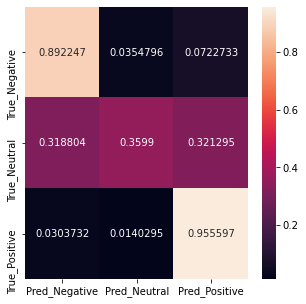

In [27]:
# Create a confusion matrix
cm_result = pd.DataFrame(metrics.confusion_matrix(y_test.argmax(axis=1), np.around(y_test_pred, decimals=0).argmax(axis=1)),
                         index=['True_Negative', 'True_Neutral', 'True_Positive'],
                         columns=['Pred_Negative', 'Pred_Neutral', 'Pred_Positive'])

display(cm_result)

plt.figure(figsize = (5,5))
sns.heatmap(cm_result.astype('float') / cm_result.sum(axis=1).values[:, np.newaxis],
            annot=True, fmt='g', annot_kws={"size": 10})
plt.show()

- We can see that the model has a problem to classify neutral reviews.
- On the other hand, it is great classifing negative and positive reviews.
- Keep in mind it hasn't gone through hyperparameter tuning.

## 7 - Let's see how it performs on some real test text

In [42]:
# Define values for predictions
sentiment = ['Negative', 'Neutral','Positive']

In [48]:
# Correct rating: 5
input_text = ["Love this stand. It works great on my desk. My favorite part and the reason I chose this stand over others that are smilar was the place for the charging cable. You do not have to disconnect the charger to remove this phone from the stand. The design allows you to pick up the phone from the stand with the charger still plugged in. Others do not have an open top. So you have to thread the cable through a hole so it becomes a pain to pick up and put down your phone."]
input_text = tokenizer.texts_to_sequences(input_text)
input_text = pad_sequences(input_text, maxlen=max_len)
input_text_pred = sentiment[np.around(best_model.predict(input_text), decimals=0).argmax(axis=1)[0]]
input_text_pred

'Positive'

In [57]:
# Correct rating: 1
input_text = ["Phone cracked. Was in the Jean pocket. All I did was bend my knee. Now you can't see half of screen. I do not recommend anyone purchasing this phone."]
input_text = tokenizer.texts_to_sequences(input_text)
input_text = pad_sequences(input_text, maxlen=max_len)
input_text_pred = sentiment[np.around(best_model.predict(input_text), decimals=0).argmax(axis=1)[0]]
input_text_pred

'Negative'

In [47]:
# Correct rating: 5
input_text = ["This was a gift for my wife and she LOVED IT! It's sturdy and she can avoid sunlight glare because of the angle adjustment. She uses it EVERYDAY. I ordered another one for me, OBVIOUSLY, NOT PINK. Thanks for this great"]
input_text = tokenizer.texts_to_sequences(input_text)
input_text = pad_sequences(input_text, maxlen=max_len)
input_text_pred = sentiment[np.around(best_model.predict(input_text), decimals=0).argmax(axis=1)[0]]
input_text_pred

'Positive'

In [65]:
# Correct rating: 1
input_text = ["It keeps shutting on and off!!! Was very mad needed this really badly for my grandmother"]
input_text = tokenizer.texts_to_sequences(input_text)
input_text = pad_sequences(input_text, maxlen=max_len)
input_text_pred = sentiment[np.around(best_model.predict(input_text), decimals=0).argmax(axis=1)[0]]
input_text_pred

'Negative'

In [74]:
# Correct rating: 3
input_text = ["I bought my N97 from Amazon in July, but since day one it shuts down on me at least once a day. This is really annoying specially when it does not turn back on immediately. Besides this inconvenience, the N97 is really a great phone with nice features and a much easier to use touchscreen when compared to the Iphone."]
input_text = tokenizer.texts_to_sequences(input_text)
input_text = pad_sequences(input_text, maxlen=max_len)
input_text_pred = sentiment[np.around(best_model.predict(input_text), decimals=0).argmax(axis=1)[0]]
input_text_pred

'Neutral'

-----------------------